<a href="https://colab.research.google.com/github/festusdrakon/SaveSheldon/blob/master/sarcasm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!unzip '/content/drive/My Drive/train-balanced-sarcasm.csv.zip'

Archive:  /content/drive/My Drive/train-balanced-sarcasm.csv.zip
  inflating: train-balanced-sarcasm.csv  


In [0]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from plotly import tools
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
from collections import defaultdict
from matplotlib import pyplot as plt
%matplotlib inline
import re
import torch
from torch.utils.data import DataLoader, TensorDataset

In [0]:
train_data=pd.read_csv('/content/train-balanced-sarcasm.csv')

In [0]:
train_data.head()

,label,comment,author,subreddit,score,ups,downs,date,created_utc,parent_comment
0,0,NC and NH.,Trumpbart,politics,2,-1,-1,2016-10,2016-10-16 23:55:23,"Yeah, I get that argument. At this point, I'd ..."
1,0,You do know west teams play against west teams...,Shbshb906,nba,-4,-1,-1,2016-11,2016-11-01 00:24:10,The blazers and Mavericks (The wests 5 and 6 s...
2,0,"They were underdogs earlier today, but since G...",Creepeth,nfl,3,3,0,2016-09,2016-09-22 21:45:37,They're favored to win.
3,0,"This meme isn't funny none of the ""new york ni...",icebrotha,BlackPeopleTwitter,-8,-1,-1,2016-10,2016-10-18 21:03:47,deadass don't kill my buzz
4,0,I could use one of those tools.,cush2push,MaddenUltimateTeam,6,-1,-1,2016-12,2016-12-30 17:00:13,Yep can confirm I saw the tool they use for th...


In [0]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1010826 entries, 0 to 1010825
Data columns (total 10 columns):
label             1010826 non-null int64
comment           1010773 non-null object
author            1010826 non-null object
subreddit         1010826 non-null object
score             1010826 non-null int64
ups               1010826 non-null int64
downs             1010826 non-null int64
date              1010826 non-null object
created_utc       1010826 non-null object
parent_comment    1010826 non-null object
dtypes: int64(4), object(6)
memory usage: 77.1+ MB


In [0]:
train_data.dropna(subset=['comment'], inplace=True)

In [0]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1010773 entries, 0 to 1010825
Data columns (total 10 columns):
label             1010773 non-null int64
comment           1010773 non-null object
author            1010773 non-null object
subreddit         1010773 non-null object
score             1010773 non-null int64
ups               1010773 non-null int64
downs             1010773 non-null int64
date              1010773 non-null object
created_utc       1010773 non-null object
parent_comment    1010773 non-null object
dtypes: int64(4), object(6)
memory usage: 84.8+ MB


In [0]:
train_data['label'].unique()

array([0, 1])

In [0]:
train_data.loc[train_data['label'] == 1, 'comment'].str.len()

33          35
44         145
45         107
66          67
69          65
74          40
76         116
160         30
169         56
193        182
194         58
216        188
230         56
255        100
274         22
278         60
305         33
336         42
346         34
359         28
370         39
443         96
457         28
479        139
487         43
497         35
508         34
526         26
556         48
575          5
          ... 
1010794     69
1010795     49
1010796      5
1010797     65
1010798     20
1010799      9
1010800     64
1010801    143
1010802    184
1010803     21
1010805     38
1010806     20
1010807    219
1010808     53
1010809    338
1010810     23
1010811     17
1010812     65
1010813     25
1010814    131
1010816     13
1010817     77
1010818     34
1010819     38
1010820      2
1010821     92
1010822     34
1010823     66
1010824     53
1010825     72
Name: comment, Length: 505368, dtype: int64

In [0]:
cnt_label = train_data['label'].value_counts()
print(cnt_label)
labels = (np.array(cnt_label.index))
sizes=(np.array((cnt_label/cnt_label.sum())*100))
print(sizes)
trace = go.Pie(labels=labels, values=sizes)
layout = go.Layout(title='Label Distribution', font=dict(size=15),
                  width=700, height=700)

data = [trace]
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename="LabelDistribution")

0    505405
1    505368
Name: label, dtype: int64
[50.00183028 49.99816972]


In [0]:
def horizontal_bar_chart(df, color):
    trace = go.Bar(y = df["word"].values[::-1],
                  x = df["wordcount"].values[::-1],
                  showlegend=False,
                  orientation='h',
                  marker=dict(color=color))
    return trace

In [0]:
train1_df = train_data[train_data['label']==1]
train0_df = train_data[train_data['label']==0]
from wordcloud import WordCloud, STOPWORDS
def generate_ngrams(text, n_gram=1):
    token = [token for token in text.lower().split(" ") if token!= "" if token not
            in STOPWORDS]
    
    ngrams = zip(*[token[i:] for i in range(n_gram)])
    return [" ".join(ngram) for ngram in ngrams]

freq_dict = defaultdict(int)
for sent in train0_df["comment"]:
    for word in generate_ngrams(sent):
      freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace1 = horizontal_bar_chart(fd_sorted.head(50), 'blue')
      

In [0]:
sub_df = train_data.groupby('subreddit')['label'].agg([np.size, np.mean, np.sum])
sub_df.sort_values(by='sum', ascending=False).head(10)

,size,mean,sum
subreddit,,,
AskReddit,65674,0.401453,26365
politics,39493,0.605348,23907
worldnews,26376,0.642516,16947
leagueoflegends,21034,0.542312,11407
pcmasterrace,18987,0.566651,10759
news,16891,0.603457,10193
funny,17939,0.451474,8099
pics,16152,0.484336,7823
todayilearned,14159,0.547567,7753


In [0]:
sub_df[sub_df['size'] > 1000].sort_values(by='mean', ascending=False).head(10)


,size,mean,sum
subreddit,,,
creepyPMs,5466,0.784303,4287
MensRights,3355,0.680775,2284
ShitRedditSays,1284,0.661994,850
worldnews,26376,0.642516,16947
Libertarian,2562,0.640125,1640
atheism,7377,0.639555,4718
Conservative,1881,0.639553,1203
TwoXChromosomes,1560,0.632692,987
fatlogic,2356,0.623090,1468


In [0]:
train_data['comment']=train_data['comment'].str.lower()
train_data['parent_comment']=(train_data['parent_comment']).str.lower()
train_data['author']=(train_data['comment']).str.lower()
train_data['subreddit']=(train_data['subreddit']).str.lower()

In [0]:
train_data['comment']=train_data['comment'].replace('[^\w\s]','', regex=True)
train_data['parent_comment']=train_data['parent_comment'].replace('[^\w\s]','', regex=True)
train_data['author']=train_data['author'].replace('[^\w\s]','', regex=True)
train_data['subreddit']=train_data['subreddit'].replace('[^\w\s]','', regex=True)

In [0]:
train_data['parent_comment'][4]

'yep can confirm i saw the tool they use for that it was made by our boy easports_mut'

In [0]:
train_data.head(3)

,label,comment,author,subreddit,score,ups,downs,date,created_utc,parent_comment
0,0,nc and nh,nc and nh,politics,2,-1,-1,2016-10,2016-10-16 23:55:23,yeah i get that argument at this point id pref...
1,0,you do know west teams play against west teams...,you do know west teams play against west teams...,nba,-4,-1,-1,2016-11,2016-11-01 00:24:10,the blazers and mavericks the wests 5 and 6 se...
2,0,they were underdogs earlier today but since gr...,they were underdogs earlier today but since gr...,nfl,3,3,0,2016-09,2016-09-22 21:45:37,theyre favored to win


In [0]:
train_data.drop(['author','subreddit','score','ups','downs','date','created_utc'], axis=1, inplace=True)

In [0]:
train_data.drop(['parent_comment'], axis=1, inplace=True)

In [0]:
from string import punctuation
print(punctuation)

!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~


In [0]:
all_reviews=list()
for text in train_data['comment']:
  text = text.lower()
  text = "".join([ch for ch in text if ch not in punctuation])
  all_reviews.append(text)
all_text = " ".join(all_reviews)
all_words = all_text.split()

In [0]:
print(all_words[:10])

['nc', 'and', 'nh', 'you', 'do', 'know', 'west', 'teams', 'play', 'against']


In [0]:
print(type(all_words))

<class 'list'>


In [0]:
from collections import Counter 
# Count all the words using Counter Method
count_words = Counter(all_words)
total_words=len(all_words)
(sorted_words)=count_words.most_common(total_words)
print(sorted_words[:10])
#print("Top ten occuring words : "+sorted_words[:10])

[('the', 396228), ('a', 244958), ('to', 239184), ('i', 184355), ('and', 173669), ('you', 171489), ('is', 154657), ('of', 149812), ('that', 140694), ('it', 128142)]


In [0]:
vocab_to_int={w:i+1 for i,(w,c) in enumerate(sorted_words)}
#print(vocab_to_int)

In [0]:
encoded_reviews=list()
for review in all_reviews:
  encoded_review=list()
  for word in review.split():
    if word not in vocab_to_int.keys():
      #if word is not available in vocab_to_int put 0 in that place
      encoded_review.append(0)
    else:
      encoded_review.append(vocab_to_int[word])
  encoded_reviews.append(encoded_review)

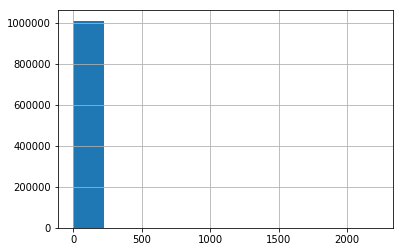

count    1.010773e+06
mean     1.042197e+01
std      1.050239e+01
min      0.000000e+00
25%      5.000000e+00
50%      9.000000e+00
75%      1.400000e+01
max      2.222000e+03
dtype: float64

In [0]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
reviews_len = [len(x) for x in encoded_reviews]
pd.Series(reviews_len).hist()
plt.show()
pd.Series(reviews_len).describe()

In [0]:
sequence_length=500
features=np.zeros((len(encoded_reviews), sequence_length), dtype=int)
for i, review in enumerate(encoded_reviews):
  review_len=len(review)
  if (review_len<=sequence_length):
    zeros=list(np.zeros(sequence_length-review_len))
    new=zeros+review
  else:
    new=review[:sequence_length]
features[i,:]=np.array(new)

In [0]:
labels=train_data['label']

In [0]:
train_x=features[:int(0.8*len(features))]
train_y=labels[:int(0.8*len(features))]
valid_x=features[int(0.8*len(features)):]
valid_y=labels[int(0.8*len(features)):]
train_y=train_y.to_numpy()
valid_y=valid_y.to_numpy()
print(type(train_x), len(valid_y))
print(len(train_data))

<class 'numpy.ndarray'> 202155
1010773


In [0]:
traindata = TensorDataset(torch.from_numpy(train_x), torch.from_numpy(train_y))
validdata = TensorDataset(torch.from_numpy(valid_x), torch.from_numpy(valid_y))

In [0]:
batch_size=50
train_loader=DataLoader(traindata, batch_size=batch_size, shuffle=True)
valid_loader=DataLoader(validdata, batch_size=batch_size, shuffle=True)

In [0]:
dataiter = iter(train_loader)
sample_x, sample_y = dataiter.next()
print('Sample input size: ', sample_x.size()) # batch_size, seq_length
print('Sample input: \n', sample_x)
print()
print('Sample label size: ', sample_y.size()) # batch_size
print('Sample label: \n', sample_y)

Sample input size:  torch.Size([50, 500])
Sample input: 
 tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]])

Sample label size:  torch.Size([50])
Sample label: 
 tensor([1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0,
        1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0,
        0, 1])


In [0]:
import torch.nn as nn

class SentimentLSTM(nn.Module):
    

    def __init__(self, vocab_size, output_size, embedding_dim, hidden_dim, n_layers, drop_prob=0.5):
        """
        Initialize the model by setting up the layers.
        """
        super().__init__()

        self.output_size = output_size
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim
        
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, n_layers, 
                            dropout=drop_prob, batch_first=True)
        
 
        self.dropout = nn.Dropout(0.3)
        
        
        self.fc = nn.Linear(hidden_dim, output_size)
        self.sig = nn.Sigmoid()
        

    def forward(self, x, hidden):
       
        batch_size = x.size(0)

        
        embeds = self.embedding(x)
        lstm_out, hidden = self.lstm(embeds, hidden)
    
        
        lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim)
        out = self.dropout(lstm_out)
        out = self.fc(out)
        
        sig_out = self.sig(out)
        
        sig_out = sig_out.view(batch_size, -1)
        sig_out = sig_out[:, -1] 
        return sig_out, hidden
    
    
    def init_hidden(self, batch_size):
        
        weight = next(self.parameters()).data
        
        if (train_on_gpu):
            hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().cuda(),
                  weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().cuda())
        else:
            hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_(),
                      weight.new(self.n_layers, batch_size, self.hidden_dim).zero_())
        
        return hidden
        

In [0]:
vocab_size = len(vocab_to_int)+1 # +1 for the 0 padding
output_size = 1
embedding_dim = 400
hidden_dim = 256
n_layers = 2
net = SentimentLSTM(vocab_size, output_size, embedding_dim, hidden_dim, n_layers)
print(net)

SentimentLSTM(
  (embedding): Embedding(206968, 400)
  (lstm): LSTM(400, 256, num_layers=2, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.3)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (sig): Sigmoid()
)


In [0]:
import torch
import torch.nn as nn
train_on_gpu = torch.cuda.is_available()
lr=0.001

criterion = nn.BCELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=lr)

epochs = 4 

counter = 0
print_every = 100
clip=5
if(train_on_gpu):
    net.cuda()

net.train()
for e in range(epochs):
    
    h = net.init_hidden(batch_size)
    for inputs, labels in train_loader:
        counter += 1

        if(train_on_gpu):
            inputs, labels = inputs.cuda(), labels.cuda()

            h = tuple([each.data for each in h])

        # zero accumulated gradients
        net.zero_grad()

        # get the output from the model
        inputs = inputs.type(torch.cuda.LongTensor)
        output,h = net(inputs, h)
        print(output.shape)
        # calculate the loss and perform backprop
        loss = criterion(output.squeeze(), labels.float())
        loss.backward(retain_graph=True)
        
        nn.utils.clip_grad_norm_(net.parameters(), clip)
        optimizer.step()

       
        if counter % print_every == 0:
            
            val_h = net.init_hidden(batch_size)
            val_losses = []
            net.eval()
            for inputs, labels in valid_loader:

                
                val_h = tuple([each.data for each in val_h])

                if(train_on_gpu):
                    inputs, labels = inputs.cuda(), labels.cuda()

                inputs = inputs.type(torch.cuda.LongTensor)
                output, val_h = net(inputs, val_h)
                val_loss = criterion(output.squeeze(), labels.float())

                val_losses.append(val_loss.item())

            net.train()
            print("Epoch: {}/{}...".format(e+1, epochs),
                  "Step: {}...".format(counter),
                  "Loss: {:.6f}...".format(loss.item()),
                  "Val Loss: {:.6f}".format(np.mean(val_losses)))

RuntimeError: ignored